# Projeto 1 - Titanic

## Usar Machine Learning para criar um modelo para fazer uma previsão de qual passageiros sobreviveram no naufrago do Titanic

#### 1. Carregando os Dados

In [83]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Carregando os datasets
train = pd.read_csv(r"C:\Users\josaf\Documents\Cientista de dados\Curso\data\titanic\train.csv")
test = pd.read_csv(r"C:\Users\josaf\Documents\Cientista de dados\Curso\data\titanic\test.csv")

# Visualizando os primeiros dados
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [84]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### 2. Análise Exploratória

In [85]:
# Taxa de sobrevivência geral
print(f"Taxa de sobrevivência: {train['Survived'].mean():.2f}")

Taxa de sobrevivência: 0.38


In [86]:
# Taxa de sobrevivência por sexo
print(train.groupby('Sex')['Survived'].mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


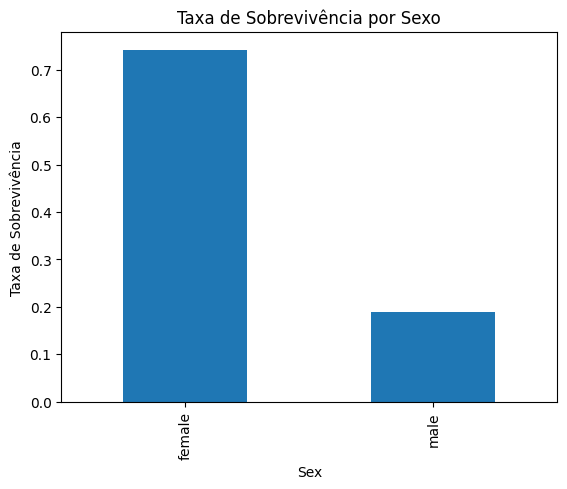

In [87]:
# Visualizando taxa de sobrevivência por sexo
train.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Taxa de Sobrevivência por Sexo')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

In [88]:
# Taxa de sobrevivência por classe
print(train.groupby('Pclass')['Survived'].mean())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


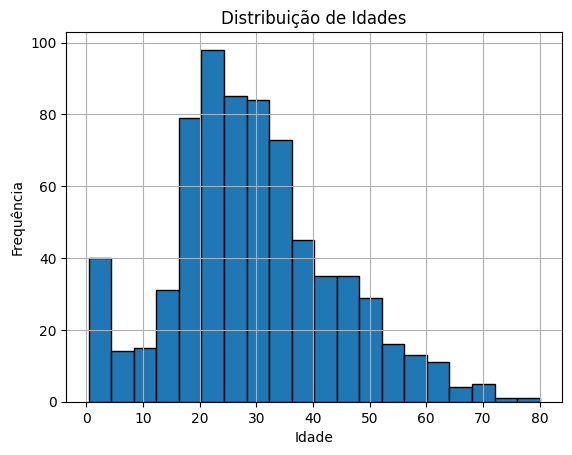

In [89]:
# Histograma de Idade
train['Age'].hist(bins=20, edgecolor='black')
plt.title('Distribuição de Idades')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

#### 3. Tratamento de Dados

In [90]:
# Tratando valores ausentes
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [91]:
# Criando categorias para idade
bins = [0, 12, 18, 60, 120]
labels = ['Child', 'Teenager', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels)

In [92]:
# Extraindo títulos dos nomes
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [93]:
# Agrupando títulos raros
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')
test['Title'] = test['Title'].replace(rare_titles, 'Rare')

In [94]:
# Criando variável 'IsAlone' para indicar se o passageiro estava sozinho
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']
train['IsAlone'] = (train['FamilySize'] == 0).astype(int)
test['IsAlone'] = (test['FamilySize'] == 0).astype(int)

In [95]:
# Codificando variáveis categóricas
categorical_features = ['Sex', 'Embarked', 'AgeGroup', 'Title']
train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

In [96]:
# Removendo a coluna 'Cabin' (muitos valores ausentes)
train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

In [97]:
# Criando a variável 'FamilySize'
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

In [98]:
# Convertendo variáveis categóricas em numéricas
#train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
#test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

In [99]:
# Codificando 'Embarked' com One-Hot Encoding
#train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
#test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

In [100]:
# Selecionando as colunas relevantes
X = train.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = train['Survived']
X_test = test.drop(columns=['Name', 'Ticket', 'PassengerId'])

#### 4. Dividindo os Dados para Treinamento e Validação

In [101]:
# Dividindo os dados
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### 5. Treinando o Modelo

In [102]:
# Treinando o modelo com Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Avaliando o modelo
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Acurácia no conjunto de validação: {accuracy:.2f}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_val, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)


Acurácia no conjunto de validação: 0.82
Matriz de Confusão:
[[89 16]
 [17 57]]


#### 6. Otimizando o Modelo

In [103]:
# Ajustando hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Avaliando o modelo otimizado
y_pred_optimized = best_model.predict(X_val)
accuracy_optimized = accuracy_score(y_val, y_pred_optimized)
print(f"Acurácia após otimização: {accuracy_optimized:.2f}")


Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Acurácia após otimização: 0.81


#### 7. Fazendo Previsões

In [104]:
# Fazendo previsões no conjunto de teste
test['Survived'] = best_model.predict(X_test)

# Criando o arquivo submission.csv
submission = test[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)
print("Arquivo submission.csv criado com sucesso!")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Title_Mlle
- Title_Mme
